<a href="https://colab.research.google.com/github/mtszkw/kleidung/blob/main/mobilenet_classification_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# !pip show pandas numpy matplotlib tensorflow optuna albumentations
!pip install --quiet tensorflow==2.4.1 matplotlib==3.2.2 pandas==1.1.5 numpy==1.19.5 albumentations==0.1.12

In [55]:
# https://github.com/alexeygrigorev/clothing-dataset-small
!git clone https://github.com/alexeygrigorev/clothing-dataset-small

fatal: destination path 'clothing-dataset-small' already exists and is not an empty directory.


In [93]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [57]:
class Config:
    seed = 2020
    batch_size = 64
    img_width = 224
    img_height = 224
    num_classes = 10
    num_epochs = 200
    init_lr = 2e-3
    dataset_directory = "./clothing-dataset-small/"
    checkpts_directory ="/content/mobilenet_fashion_clothes_clf/"

config = Config()

In [58]:
"""
    Converts image pixel values to [0, 255] range.
    This seems to be necessary for this dataset as
    MobileNetV2 doesn't handle [-1, 1] range properly.
"""
def preprocess_func(img):
    img = cv2.normalize(
        img, None, alpha=0, beta=255,
        norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    img = preprocess_input(img)
    return img

transforms = {
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
}

train_gen = ImageDataGenerator(preprocessing_function=preprocess_func, **transforms)
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_func, **transforms)

train_ds = train_gen.flow_from_directory(
    os.path.join(dataset_directory, "train/"),
    seed=config.seed,
    target_size=(config.img_width, config.img_height),
    batch_size=config.batch_size,
    shuffle=True)

val_ds = valid_gen.flow_from_directory(
    os.path.join(dataset_directory, "validation/"),
    seed=config.seed,
    target_size=(config.img_width, config.img_height),
    batch_size=config.batch_size,
    shuffle=False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [59]:
def get_model(config):
    # MobileNetV2 because it's the most lightweight model available in Keras API
    # and I would prefer model size (also for inference) rather than complexity here.
    # https://keras.io/api/applications/mobilenet/#mobilenetv2-function
    mobileNet_base = MobileNetV2(
        input_shape=(config.img_width, config.img_height, 3),
        include_top=False,
        weights="imagenet",
        classes=config.num_classes,
        classifier_activation="softmax",
    )

    mobileNet_base.trainable = False

    model = tf.keras.Sequential()
    model.add(mobileNet_base)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model


model = get_model(config)
model.compile(
    optimizer=tf.keras.optimizers.Adam(config.init_lr),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

### Training

In [60]:
lr_sched = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', min_delta=0.01, patience=5, factor=0.25, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.01, patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.num_epochs,
    verbose=1,
    batch_size=batch_size,
    callbacks=[lr_sched, early_stop])

model.save(config.checkpts_directory)

Epoch 1/10
48/48 [==============================] - 48s 950ms/step - loss: 1.5274 - accuracy: 0.5013 - val_loss: 0.7063 - val_accuracy: 0.7742
Epoch 2/10
48/48 [==============================] - 44s 916ms/step - loss: 0.8104 - accuracy: 0.7069 - val_loss: 0.6833 - val_accuracy: 0.7566
Epoch 3/10
48/48 [==============================] - 44s 917ms/step - loss: 0.6896 - accuracy: 0.7574 - val_loss: 0.5903 - val_accuracy: 0.8094
Epoch 4/10
48/48 [==============================] - 44s 924ms/step - loss: 0.6694 - accuracy: 0.7671 - val_loss: 0.5753 - val_accuracy: 0.7977
Epoch 5/10
48/48 [==============================] - 45s 941ms/step - loss: 0.5515 - accuracy: 0.8186 - val_loss: 0.5511 - val_accuracy: 0.8065
Epoch 6/10
48/48 [==============================] - 45s 943ms/step - loss: 0.5475 - accuracy: 0.8106 - val_loss: 0.6118 - val_accuracy: 0.7801
Epoch 7/10
48/48 [==============================] - 44s 928ms/step - loss: 0.5261 - accuracy: 0.8190 - val_loss: 0.5899 - val_accuracy: 0.7947

### Training History Visualization

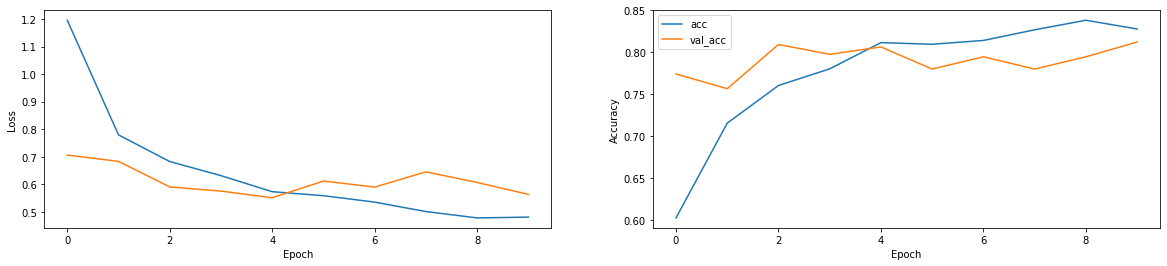

In [65]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(history.history['accuracy'], label='acc')
axs[1].plot(history.history['val_accuracy'], label='val_acc')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')

plt.legend();
plt.show();

### Inference

In [83]:
inference_model = tf.keras.models.load_model(os.path.join(config.checkpts_directory, "mobilenet_fashion_clothes_clf"))
# print(inference_model)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_func)
test_ds = train_gen.flow_from_directory(
    os.path.join(dataset_directory, "test/"),
    seed=config.seed,
    target_size=(config.img_width, config.img_height),
    batch_size=config.batch_size,
    shuffle=False)

y_pred = inference_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = 


Found 372 images belonging to 10 classes.


(372, 10)

### Confusion Matrix

In [110]:
class_names = test_ds.class_indices
class_names_list = list(class_names.keys())
class_names = {v: k for k, v in class_names.items()}

y_pred_labels = [class_names[x] for x in y_pred]
y_true_labels = [class_names[x] for x in test_ds.classes]
cm = confusion_matrix(y_pred_labels, y_true_labels)

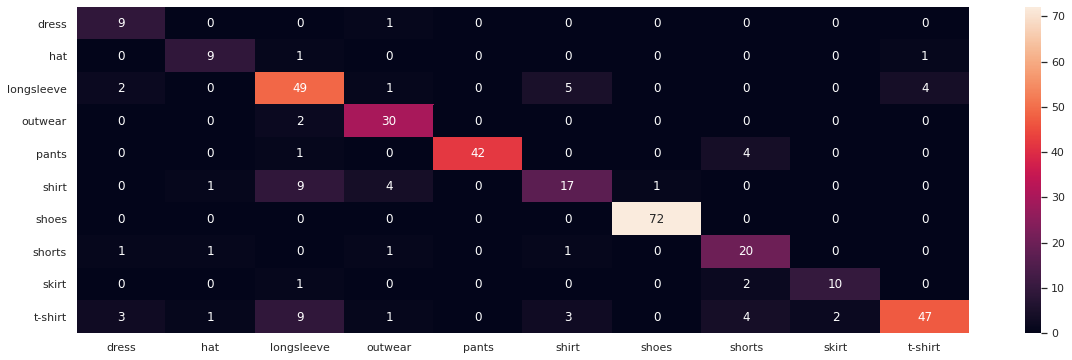

In [111]:
plt.figure(figsize=(20, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names_list, yticklabels=class_names_list)
plt.show()